In [2]:
#Hedging our bets muni-style

In [40]:
#import statements for packages/libraries
#which libraries do we need?
#pyfolio
#scipy
#backtester

import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import hvplot.pandas
from dotenv import load_dotenv
import panel as pn
from panel.interact import interact
from panel import widgets
import alpaca_trade_api as tradeapi
import quandl
import os
import requests

In [41]:
#pull in data from API (7-ish years of data 1/1/2013-11/01/2020)
#bonds--bloomberg
#muni etf (MUB)--alpaca
#swap--bloomberg or alpaca
#treasury--quandl
#treasury ETF (TLT)--alpaca

In [42]:
load_dotenv()

True

In [43]:
#import

api_key_QD = os.getenv("QUANDL_API_KEY")
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
# type(api_key_QD)
# type(alpaca_api_key)

In [44]:
#import alpaca api file for ETF price history
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Format current date as ISO format
start_date = pd.Timestamp("2013-01-02", tz="America/New_York").isoformat()
today = pd.Timestamp("2020-11-02", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["MUB", "TLT", "UDN", "UUP","LQD","JNK"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get closing prices
df_ETFs = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = today
).df

# Preview DataFrame
# YOUR CODE HERE!
df_ETFs.head()

# Output the data to CSV
df_ETFs.to_csv("Resources/ETFs1.csv", encoding='utf-8', index=True)

In [45]:
ETF_csv = Path("Resources/ETFs.csv")
ETF_df = pd.read_csv(ETF_csv, index_col='Unnamed: 0', infer_datetime_format=True, parse_dates=True)
#ETF_df.rename(columns={'Unnamed: 0': 'Date'}, inplace = True)
ETF_df = ETF_df.drop(ETF_df.index[0])
#ETF_df['Date'] = pd.to_datetime(ETF_df['Date'], utc=True)
ETF_df.index = pd.to_datetime(ETF_df.index, utc=True).date
#ETF_df['Date']= ETF_df['Date'].dt.strftime('%m/%d/%Y')
ETF_df.sort_index(inplace=True)

#drop unneccessary columns and keep close price columns
ETF_close_prices_df = ETF_df.loc[:, ['JNK.3', 'LQD.3', 'MUB.3', 'TLT.3', 'UDN.3', 'UUP.3']]
ETF_close_prices_df.rename(columns={'JNK.3': 'JNK',
                   'LQD.3': 'LQD',
                   'MUB.3': 'MUB',
                   'TLT.3': 'TLT',
                   'UDN.3': 'UDN',
                   'UUP.3': 'UUP',
                  }, inplace=True)

ETF_close_prices_df[['JNK', 'LQD', 'MUB', 'TLT', 'UDN', 'UUP']] = ETF_close_prices_df[['JNK', 'LQD', 'MUB', 'TLT', 'UDN', 'UUP']].astype(float)
ETF_close_prices_df.dtypes

#calculate daily returns
ETF_daily_returns_df = ETF_close_prices_df.pct_change().dropna()
ETF_daily_returns_df.head()

,JNK,LQD,MUB,TLT,UDN,UUP
2013-01-03,-0.002194,-0.005525,0.000002,-0.013632,-0.008094,0.007791
2013-01-04,0.001221,-0.000415,-0.001968,0.003900,-0.000371,0.000000
2013-01-07,0.002196,0.001410,0.001434,0.000210,0.003340,-0.002729
2013-01-08,-0.000487,0.001077,0.001790,0.006714,-0.001294,0.000912
2013-01-09,0.000974,-0.000153,0.002501,-0.001007,-0.003148,0.002733


In [46]:
#import quandl api file for US Treasury Rate history
USTREASURY_data = quandl.get('USTREASURY/YIELD', start_date='2013-01-01', end_date='2020-11-06',authtoken=api_key_QD)
#USTREASURY_data.to_csv('Resources/USTREASURY1.csv', encoding='utf-8', index=True)
USTREASURY_data.head()
columns_to_drop = ['1 MO', '2 MO', '3 MO', '6 MO']
USTREASURY_data.drop(columns=columns_to_drop, inplace=True)
USTREASURY_data.sort_index(inplace=True)

#create new dataframe with maturity values
columns = []
tsy_mty_df = USTREASURY_data.copy()
for column in USTREASURY_data.columns:
    maturity = ''
    for item in column.split():
        if item.isdigit():
            maturity = maturity + item
    #print(int(maturity[0]))
    tsy_mty_df[column] = int(maturity)
    columns.append(maturity)
USTREASURY_data.columns = columns
tsy_mty_df.columns = columns

#USTREASURY_data.head()
#tsy_mty_df.head()

#define function for calculating Treasury bond prices
def bondprice(fv, c, ytm, t, m):
    bondprice = ((fv*c/m*(1-(1+ytm/m)**(-m*t)))/(ytm/m)) + fv*(1+(ytm/m))**(-m*t)
    return(bondprice)

#bondprice(1000,0.06,0.08,9,2)
#bondprice(100,0.0015,0.0014,1,2)

#create new dataframe with treasury bond prices
fv = 100
c = USTREASURY_data.shift(1)/100
ytm = USTREASURY_data/100
m = 2
t = tsy_mty_df
USTREASURY_daily_prices = bondprice(fv, c, ytm, t, m)

USTREASURY_data_daily_returns = USTREASURY_daily_prices.pct_change().dropna()
#USTREASURY_data_daily_returns.head()
USTREASURY_data_daily_returns.columns = USTREASURY_data_daily_returns.columns.astype(int)
USTREASURY_data_daily_returns.head()
#tsy_mty_df.head()

,1,2,3,5,7,10,20,30
Date,,,,,,,,
2013-01-04,0.000000e+00,0.000000,0.000596,0.001961,0.003348,0.004555,0.010880,0.019705
2013-01-07,0.000000e+00,0.000000,0.000298,0.000489,0.001334,0.001813,0.000000,-0.003873
2013-01-08,9.989510e-05,0.000399,0.000894,0.001468,0.001335,0.001814,0.006173,0.007816
2013-01-09,7.485769e-09,-0.000199,-0.000595,-0.000488,-0.001332,-0.001809,-0.004600,-0.007755
2013-01-10,-1.997777e-04,-0.000598,-0.000298,-0.002444,-0.002667,-0.003624,-0.006156,-0.003898


In [47]:
# pull in LIBOR swaps to create pct_change df
## the sort_index for dates doesn't seem to be working...
swaps_csv = Path("Resources/libor_swaps.csv")
swaps_df = pd.read_csv(swaps_csv, index_col='Date', infer_datetime_format=True, parse_dates=True)
#swaps_df.set_index('Date',inplace=True)
swaps_df.sort_index(inplace=True)

swaps_mty_df = swaps_df.copy()
for column in swaps_df.columns:
    swaps_mty_df[column] = int(column)

#create new dataframe with libor swap value (using bond price function)
fv = 100
c = swaps_df.shift(1)/100
ytm = swaps_df/100
m = 2
t = swaps_mty_df
swaps_df_values = bondprice(fv, c, ytm, t, m)

swaps_daily_returns = swaps_df_values.pct_change().dropna()
swaps_daily_returns.columns = swaps_daily_returns.columns.astype(int)
swaps_daily_returns.head()

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-04,-0.000075,1.592528e-04,0.000937,0.002012,0.002907,0.004501,0.005588,0.006527,0.007239,0.007001,...,0.017842,0.019946,0.022125,0.024376,0.026719,0.026233,0.025878,0.025457,0.024973,0.023861
2013-01-07,0.000105,2.487869e-04,0.000193,-0.000020,-0.000599,-0.000751,-0.001196,-0.001533,-0.001365,-0.000045,...,-0.007280,-0.007515,-0.007740,-0.007956,-0.008181,-0.008912,-0.009864,-0.010840,-0.011838,-0.011675
2013-01-08,0.000060,1.587331e-08,0.000178,0.000571,0.001156,0.001701,0.002164,0.002699,0.002905,0.002540,...,0.008313,0.008088,0.007822,0.007518,0.007896,0.008098,0.008483,0.008868,0.009255,0.009059
2013-01-09,-0.000020,1.992080e-05,0.000054,-0.000390,-0.000682,-0.001248,-0.001594,-0.001794,-0.002400,-0.003120,...,-0.007774,-0.007536,-0.007260,-0.006945,-0.007393,-0.007308,-0.007295,-0.007268,-0.007226,-0.008247
2013-01-10,-0.000085,-3.880722e-04,-0.001192,-0.001603,-0.002335,-0.002630,-0.003025,-0.004040,-0.003969,-0.003550,...,-0.003663,-0.003946,-0.004235,-0.004529,-0.003933,-0.004217,-0.004506,-0.004800,-0.005098,-0.004240


In [48]:
#pull in bond prices and create dataframe
bonds_csv = Path("Resources/bonds_example_prices_larger.csv")
bonds_df = pd.read_csv(bonds_csv, index_col='Date',infer_datetime_format=True, parse_dates=True)
bonds_df.sort_index(inplace=True)

#need to wait to dropna after concat within the correlation function
bonds_daily_returns = bonds_df.pct_change()
bonds_daily_returns.head()

,57583R5Q4,751100HG6,93978HBK0,34153PC55,677561LN0,873519MZ2,160853PX9,6312944D4,73358WGG3,796253Z21,...,6461366C0,88256HAN8,167486F87,961548AR5,452152G88,880443EE2,645918V26,888808HS4,38122NZB1,64577BKL7
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,0.002309,-0.000752,0.000104,-0.004881,NaN,NaN,0.002068,-0.013797,-0.000780,-0.015999,...,NaN,0.000348,NaN,-0.002210,NaN,-0.000965,NaN,NaN,NaN,NaN
2013-01-03,0.000578,0.000336,0.001534,0.001455,NaN,NaN,0.000509,-0.009324,0.000135,-0.008318,...,NaN,0.001960,NaN,-0.005996,NaN,0.000800,NaN,NaN,NaN,NaN
2013-01-04,-0.006025,-0.000602,-0.000836,-0.001527,NaN,NaN,-0.002259,-0.002835,-0.002023,-0.000560,...,NaN,-0.003985,NaN,-0.001182,NaN,-0.006019,NaN,NaN,NaN,NaN
2013-01-05,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,...,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN


In [49]:
#pull in bond descriptions to dataframe
bondescr_csv = Path("Resources/muni_hedge_characteristics.csv")
bondescr_df = pd.read_csv(bondescr_csv)

cleaned_cusips = []
for cusipid in bondescr_df['CUSIP']:
    cusipid = cusipid.strip()
    cleaned_cusips.append(cusipid)

bondescr_df['CUSIP'] = cleaned_cusips

bondescr_df.set_index('CUSIP',inplace=True)
bondescr_df.head()

,Security,Coupon,Next Call Date,Maturity Date,Bloomberg Composite Rating,U.S States
CUSIP,,,,,,
546417DJ2,LOUISIANA ST -B -REF,5.0,NaN,11/15/2020,AA-,LA
59259YQW2,MET TRANS-D-REF,5.0,NaN,11/15/2020,BBB+,NY
59261AJX6,MET TRANSPRTN AUTH NY,5.0,NaN,11/15/2020,BBB+,NY
89602NZX5,TRIBORO BRDG-B,5.0,NaN,11/15/2020,AA-,NY
13063CHQ6,CALIFORNIA ST-VARIOUS,5.0,NaN,12/01/2020,AA-,CA


In [50]:
#function passing a cusip to put it against hedges
#what are the steps we need our function to do:
    #1.pick bond
    #2. compare versus all hedges
    #3. show correlation of bond vis a vis different hedges
#ETF_daily_returns_df, USTREASURY_data_daily_returns, swaps_daily_returns, bonds_daily_returns  
#cusip = '88256HAN8'
def historical_corr(cusip):
    # find maturity of chosen muni bond and convert to datetime
    bond_mty = bondescr_df.loc[cusip,'Maturity Date']
    bond_mty = dt.datetime.strptime(bond_mty, '%m/%d/%Y')
    bond_mty

    # create series with bond years to maturity for lookup in dataframes
    # relativedelta function: https://dateutil.readthedocs.io/en/stable/relativedelta.html
    ## make output for years more exact by looking at days/360 and rounding?
    mty_years = []
    for return_date in bonds_daily_returns.index:
        difference = relativedelta(bond_mty, return_date)
        mty_years.append(difference.years)
    #len(mty_years)

    # reference closest maturity in tsy and swap df
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    tsy_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in USTREASURY_data_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        tsy_index.append(min_item)

    swap_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in swaps_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        swap_index.append(min_item)
    #len(swap_index)
    #len(tsy_index)

    # create new dataframe to combine items
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    joined_df = pd.DataFrame(bonds_daily_returns[cusip])
    joined_df['tsy_index'] = tsy_index
    joined_df['swap_index'] = swap_index
    
    joined_df = pd.merge(joined_df, USTREASURY_data_daily_returns, left_index=True, right_index=True)

    tsy_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['tsy_index'][indx]]
        tsy_change.append(change)
    joined_df['tsy_change'] = tsy_change
    tsy_col_drop = ['tsy_index',1,2,3,5,7,10,20,30]
    joined_df.drop(columns=tsy_col_drop,inplace=True)

    joined_df = pd.merge(joined_df, swaps_daily_returns, left_index=True, right_index=True)

    swap_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['swap_index'][indx]]
        swap_change.append(change)
    joined_df['swap_change'] = swap_change
    swap_col_drop = ['swap_index',1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    joined_df.drop(columns=swap_col_drop,inplace=True)

    ##concat separate dataframes (muni etf, treasury etf)
    #ETF_daily_returns_df
    joined_df = pd.merge(joined_df, ETF_daily_returns_df, left_index=True, right_index=True)
    #joined_df.head()

    ## calculate standard deviation
    hedge_corr = joined_df.corr()
    return hedge_corr
hedge_corr = historical_corr(cusip)
hedge_corr

,64577BKL7,tsy_change,swap_change,JNK,LQD,MUB,TLT,UDN,UUP
64577BKL7,1.000000,0.050968,0.018012,0.035893,0.281163,0.472066,0.082066,0.176880,-0.150941
tsy_change,0.050968,1.000000,0.880155,-0.009280,0.381918,0.234781,0.632305,0.169629,-0.179157
swap_change,0.018012,0.880155,1.000000,-0.001606,0.300340,0.196619,0.570380,0.144204,-0.168042
JNK,0.035893,-0.009280,-0.001606,1.000000,0.053375,0.050359,-0.017392,0.012116,-0.004937
LQD,0.281163,0.381918,0.300340,0.053375,1.000000,0.686187,0.548531,0.246054,-0.198178
MUB,0.472066,0.234781,0.196619,0.050359,0.686187,1.000000,0.382497,0.228248,-0.186376
TLT,0.082066,0.632305,0.570380,-0.017392,0.548531,0.382497,1.000000,0.158435,-0.179354
UDN,0.176880,0.169629,0.144204,0.012116,0.246054,0.228248,0.158435,1.000000,-0.959371
UUP,-0.150941,-0.179157,-0.168042,-0.004937,-0.198178,-0.186376,-0.179354,-0.959371,1.000000


In [51]:
hedge_corr.style.background_gradient(cmap='YlGn_r')

,64577BKL7,tsy_change,swap_change,JNK,LQD,MUB,TLT,UDN,UUP
64577BKL7,1,0.0509681,0.018012,0.0358929,0.281163,0.472066,0.0820659,0.17688,-0.150941
tsy_change,0.0509681,1,0.880155,-0.00928025,0.381918,0.234781,0.632305,0.169629,-0.179157
swap_change,0.018012,0.880155,1,-0.00160612,0.30034,0.196619,0.57038,0.144204,-0.168042
JNK,0.0358929,-0.00928025,-0.00160612,1,0.0533749,0.0503592,-0.0173925,0.0121156,-0.00493745
LQD,0.281163,0.381918,0.30034,0.0533749,1,0.686187,0.548531,0.246054,-0.198178
MUB,0.472066,0.234781,0.196619,0.0503592,0.686187,1,0.382497,0.228248,-0.186376
TLT,0.0820659,0.632305,0.57038,-0.0173925,0.548531,0.382497,1,0.158435,-0.179354
UDN,0.17688,0.169629,0.144204,0.0121156,0.246054,0.228248,0.158435,1,-0.959371
UUP,-0.150941,-0.179157,-0.168042,-0.00493745,-0.198178,-0.186376,-0.179354,-0.959371,1


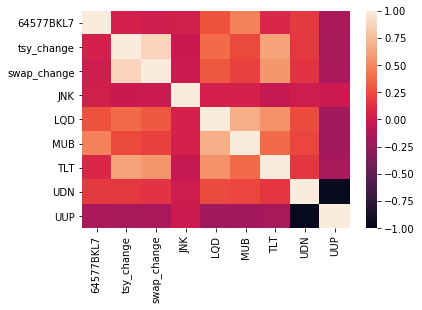

In [52]:
## heatmap
import seaborn as sns
sns.heatmap(hedge_corr, vmin=-1, vmax=1)

In [53]:
def historical_corr_test(cusip):
    # find maturity of chosen muni bond and convert to datetime
    bond_mty = bondescr_df.loc[cusip,'Maturity Date']
    bond_mty = dt.datetime.strptime(bond_mty, '%m/%d/%Y')
    bond_mty

    # create series with bond years to maturity for lookup in dataframes
    # relativedelta function: https://dateutil.readthedocs.io/en/stable/relativedelta.html
    ## make output for years more exact by looking at days/360 and rounding?
    mty_years = []
    for return_date in bonds_daily_returns.index:
        difference = relativedelta(bond_mty, return_date)
        mty_years.append(difference.years)
    #len(mty_years)

    # reference closest maturity in tsy and swap df
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    tsy_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in USTREASURY_data_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        tsy_index.append(min_item)

    swap_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in swaps_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        swap_index.append(min_item)
    #len(swap_index)
    #len(tsy_index)

    # create new dataframe to combine items
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    joined_df = pd.DataFrame(bonds_daily_returns[cusip])
    joined_df['tsy_index'] = tsy_index
    joined_df['swap_index'] = swap_index
    
    joined_df = pd.merge(joined_df, USTREASURY_data_daily_returns, left_index=True, right_index=True)

    tsy_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['tsy_index'][indx]]
        tsy_change.append(change)
    joined_df['tsy_change'] = tsy_change
    tsy_col_drop = ['tsy_index',1,2,3,5,7,10,20,30]
    joined_df.drop(columns=tsy_col_drop,inplace=True)

    joined_df = pd.merge(joined_df, swaps_daily_returns, left_index=True, right_index=True)

    swap_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['swap_index'][indx]]
        swap_change.append(change)
    joined_df['swap_change'] = swap_change
    swap_col_drop = ['swap_index',1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    joined_df.drop(columns=swap_col_drop,inplace=True)

    ##concat separate dataframes (muni etf, treasury etf)
    #ETF_daily_returns_df
    joined_df = pd.merge(joined_df, ETF_daily_returns_df, left_index=True, right_index=True)
    #joined_df.head()

    ## calculate standard deviation
    hedge_corr = joined_df.corr()
    return hedge_corr.iloc[1,0]

In [54]:
tsy_corr = []
for item in bonds_daily_returns.columns:
    cusip = item
    tsy_corr.append(historical_corr_test(cusip))
tsy_corr

[-0.023468522297164538,
 -0.06994025619589567,
 -0.028131032092505594,
 -0.020758929155357687,
 0.41604887812481195,
 -0.04052588046257571,
 -0.022395209607663766,
 0.4110613525500944,
 -0.0006513105032610149,
 0.44185435008043683,
 0.04728293681447972,
 0.08557243880126834,
 -0.04040129415305014,
 0.08675011025798295,
 -0.039233961079190374,
 0.41446023081135897,
 0.5850407573288416,
 0.35426629291375855,
 0.4876217784333873,
 -0.02883305969471078,
 -0.1486360441511309,
 0.08759035903948362,
 0.01589308912453266,
 -0.058883540643586404,
 0.00672457308776882,
 0.009641282868220904,
 0.09926742343233126,
 0.11370978538864568,
 0.05793992369831087,
 -0.04288779358852415,
 0.048259958317662596,
 nan,
 0.054666089473304584,
 0.019645401854406386,
 0.0671842494338043,
 0.07826837950038695,
 0.04979410398497747,
 -0.11463814851258433,
 -0.11453359370214415,
 0.1161587776555138,
 0.008707112879706148,
 0.052026391010598,
 0.12178540333246388,
 0.06705150414022124,
 0.10171054035698572,
 0.080

In [55]:
tsy_corr.sort(reverse=True)
print(tsy_corr)

[0.9999999999999999, 0.9331266354897704, 0.5850407573288416, 0.5450390488130064, 0.5109944230422412, 0.509535446705924, 0.5035207534089685, 0.4876217784333873, 0.4751024562979753, 0.4492519107119064, 0.44185435008043683, nan, 0.4368575435547788, 0.4331172356705258, 0.41604887812481195, 0.41446023081135897, 0.4110613525500944, 0.4064430433040248, 0.40220509471176663, 0.3659256152081954, 0.35426629291375855, 0.2688141414559524, 0.12178540333246388, 0.1161587776555138, 0.11370978538864568, 0.10931930244216329, 0.10605012030924871, 0.10179889369693396, 0.10171054035698572, 0.1013785486005931, 0.09926742343233126, 0.08759035903948362, 0.08675011025798295, 0.08557243880126834, 0.08063759653603043, 0.07826837950038695, 0.0671842494338043, 0.06705150414022124, 0.05793992369831087, 0.054666089473304584, 0.052026391010598, 0.04979410398497747, 0.048259958317662596, 0.04728293681447972, 0.043686012968272, 0.019645401854406386, 0.01589308912453266, 0.0100529169301681, 0.009641282868220904, 0.00870

In [56]:
def historical_corr_test(cusip):
    # find maturity of chosen muni bond and convert to datetime
    bond_mty = bondescr_df.loc[cusip,'Maturity Date']
    bond_mty = dt.datetime.strptime(bond_mty, '%m/%d/%Y')
    bond_mty

    # create series with bond years to maturity for lookup in dataframes
    # relativedelta function: https://dateutil.readthedocs.io/en/stable/relativedelta.html
    ## make output for years more exact by looking at days/360 and rounding?
    mty_years = []
    for return_date in bonds_daily_returns.index:
        difference = relativedelta(bond_mty, return_date)
        mty_years.append(difference.years)
    #len(mty_years)

    # reference closest maturity in tsy and swap df
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    tsy_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in USTREASURY_data_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        tsy_index.append(min_item)

    swap_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in swaps_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        swap_index.append(min_item)
    #len(swap_index)
    #len(tsy_index)

    # create new dataframe to combine items
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    joined_df = pd.DataFrame(bonds_daily_returns[cusip])
    joined_df['tsy_index'] = tsy_index
    joined_df['swap_index'] = swap_index
    
    joined_df = pd.merge(joined_df, USTREASURY_data_daily_returns, left_index=True, right_index=True)

    tsy_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['tsy_index'][indx]]
        tsy_change.append(change)
    joined_df['tsy_change'] = tsy_change
    tsy_col_drop = ['tsy_index',1,2,3,5,7,10,20,30]
    joined_df.drop(columns=tsy_col_drop,inplace=True)

    joined_df = pd.merge(joined_df, swaps_daily_returns, left_index=True, right_index=True)

    swap_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['swap_index'][indx]]
        swap_change.append(change)
    joined_df['swap_change'] = swap_change
    swap_col_drop = ['swap_index',1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    joined_df.drop(columns=swap_col_drop,inplace=True)

    ##concat separate dataframes (muni etf, treasury etf)
    #ETF_daily_returns_df
    joined_df = pd.merge(joined_df, ETF_daily_returns_df, left_index=True, right_index=True)
    #joined_df.head()

    ## calculate standard deviation
    hedge_corr = joined_df.corr()
    tsy_corr_loc = hedge_corr.iloc[1,0]
    swap_corr_loc = hedge_corr.iloc[2,0]
    jnk_corr_loc = hedge_corr.iloc[3,0]
    lqd_corr_loc = hedge_corr.iloc[4,0]
    mub_corr_loc = hedge_corr.iloc[5,0]
    tlt_corr_loc = hedge_corr.iloc[6,0]
    udn_corr_loc = hedge_corr.iloc[7,0]
    uup_corr_loc = hedge_corr.iloc[8,0]
    #update the return to display the correlations to the specific hedges
    return swap_corr_loc

In [57]:
swap_corr = []
for item in bonds_daily_returns.columns:
    cusip = item
    swap_corr.append(historical_corr_test(cusip))
swap_corr
swap_corr.sort(reverse=True)
print(swap_corr)

[1.0, 0.5132416485272109, 0.4701477489403821, 0.4365858954746577, 0.4172023995844852, 0.40305907467468016, 0.38722519960826135, 0.3824053476650236, 0.3787577420793112, nan, 0.423440259509704, 0.4193192010245834, 0.4105036452703761, 0.38274231374292234, 0.36712816500600365, 0.36128891568277594, 0.3611494475307315, 0.35858205910782165, 0.3550264786206649, 0.3488446218964926, 0.3410335047752254, 0.32677673923605055, 0.3262391539146975, 0.32545005230845186, 0.3110057690048767, 0.3036442106800339, 0.2943067506437683, 0.29302642697017867, 0.2586923221107256, 0.22121291818263533, 0.21871441399313302, 0.188325725284588, 0.13993519152145673, 0.11310852839552438, 0.10817170795490495, 0.10527280424469034, 0.10425342075707617, 0.09316622284077333, 0.09244995529129062, 0.09052503392502126, 0.08107973279373698, 0.06965706592261695, 0.06633545680436911, 0.06476089635565832, 0.06457821280904864, nan, 1.0, 0.7774973699386437, 0.7557866647129888, 0.5754534245831558, 0.5425919950267265, 0.502556324639478

In [58]:
def historical_corr_test(cusip):
    # find maturity of chosen muni bond and convert to datetime
    bond_mty = bondescr_df.loc[cusip,'Maturity Date']
    bond_mty = dt.datetime.strptime(bond_mty, '%m/%d/%Y')
    bond_mty

    # create series with bond years to maturity for lookup in dataframes
    # relativedelta function: https://dateutil.readthedocs.io/en/stable/relativedelta.html
    ## make output for years more exact by looking at days/360 and rounding?
    mty_years = []
    for return_date in bonds_daily_returns.index:
        difference = relativedelta(bond_mty, return_date)
        mty_years.append(difference.years)
    #len(mty_years)

    # reference closest maturity in tsy and swap df
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    tsy_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in USTREASURY_data_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        tsy_index.append(min_item)

    swap_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in swaps_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        swap_index.append(min_item)
    #len(swap_index)
    #len(tsy_index)

    # create new dataframe to combine items
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    joined_df = pd.DataFrame(bonds_daily_returns[cusip])
    joined_df['tsy_index'] = tsy_index
    joined_df['swap_index'] = swap_index
    
    joined_df = pd.merge(joined_df, USTREASURY_data_daily_returns, left_index=True, right_index=True)

    tsy_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['tsy_index'][indx]]
        tsy_change.append(change)
    joined_df['tsy_change'] = tsy_change
    tsy_col_drop = ['tsy_index',1,2,3,5,7,10,20,30]
    joined_df.drop(columns=tsy_col_drop,inplace=True)

    joined_df = pd.merge(joined_df, swaps_daily_returns, left_index=True, right_index=True)

    swap_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['swap_index'][indx]]
        swap_change.append(change)
    joined_df['swap_change'] = swap_change
    swap_col_drop = ['swap_index',1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    joined_df.drop(columns=swap_col_drop,inplace=True)

    ##concat separate dataframes (muni etf, treasury etf)
    #ETF_daily_returns_df
    joined_df = pd.merge(joined_df, ETF_daily_returns_df, left_index=True, right_index=True)
    #joined_df.head()

    ## calculate standard deviation
    hedge_corr = joined_df.corr()
    tsy_corr_loc = hedge_corr.iloc[1,0]
    swap_corr_loc = hedge_corr.iloc[2,0]
    jnk_corr_loc = hedge_corr.iloc[3,0]
    lqd_corr_loc = hedge_corr.iloc[4,0]
    mub_corr_loc = hedge_corr.iloc[5,0]
    tlt_corr_loc = hedge_corr.iloc[6,0]
    udn_corr_loc = hedge_corr.iloc[7,0]
    uup_corr_loc = hedge_corr.iloc[8,0]
    #update the return to display the correlations to the specific hedges
    return lqd_corr_loc

In [61]:
lqd_corr = []
for item in bonds_daily_returns.columns:
    cusip = item
    lqd_corr.append(historical_corr_test(cusip))
lqd_corr
lqd_corr.sort(reverse=True)
print(lqd_corr)

[1.0, 0.6996948535383265, 0.4620733283814791, 0.4611231701407269, nan, 0.5826118077277693, 0.5101717061597925, 0.4566544433998816, 0.453560544923884, 0.4530462078796896, 0.4389326387902152, 0.4340067617613758, 0.43340017203679443, 0.43241047558730566, 0.43021031988293024, 0.42377021465524195, 0.42288417890356783, 0.42283798359843194, 0.4114546036948855, 0.4098571084836163, 0.40819381251935144, 0.40624318490887495, 0.40610920537736295, 0.40602064207339666, 0.4058813500706189, 0.40342918580701204, 0.3979350618404235, 0.39706619512177954, 0.39588728632729986, 0.3949389115749171, 0.3887794975825389, 0.38777729445573444, 0.38714233971884743, 0.3864543467771421, 0.3756040172649297, 0.3752824813175738, 0.3730898276077304, 0.3722549269152347, 0.37160188692494756, 0.37111459879296715, 0.34325538674659806, 0.328151690042507, 0.3161167048875338, 0.31500836155250955, 0.3099403029712736, 0.30370029717292135, 0.3005655951166482, 0.2988759609174817, 0.2568843292819044, 0.2042011710344164, 0.174298085

In [62]:
def historical_corr_test(cusip):
    # find maturity of chosen muni bond and convert to datetime
    bond_mty = bondescr_df.loc[cusip,'Maturity Date']
    bond_mty = dt.datetime.strptime(bond_mty, '%m/%d/%Y')
    bond_mty

    # create series with bond years to maturity for lookup in dataframes
    # relativedelta function: https://dateutil.readthedocs.io/en/stable/relativedelta.html
    ## make output for years more exact by looking at days/360 and rounding?
    mty_years = []
    for return_date in bonds_daily_returns.index:
        difference = relativedelta(bond_mty, return_date)
        mty_years.append(difference.years)
    #len(mty_years)

    # reference closest maturity in tsy and swap df
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    tsy_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in USTREASURY_data_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        tsy_index.append(min_item)

    swap_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in swaps_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        swap_index.append(min_item)
    #len(swap_index)
    #len(tsy_index)

    # create new dataframe to combine items
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    joined_df = pd.DataFrame(bonds_daily_returns[cusip])
    joined_df['tsy_index'] = tsy_index
    joined_df['swap_index'] = swap_index
    
    joined_df = pd.merge(joined_df, USTREASURY_data_daily_returns, left_index=True, right_index=True)

    tsy_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['tsy_index'][indx]]
        tsy_change.append(change)
    joined_df['tsy_change'] = tsy_change
    tsy_col_drop = ['tsy_index',1,2,3,5,7,10,20,30]
    joined_df.drop(columns=tsy_col_drop,inplace=True)

    joined_df = pd.merge(joined_df, swaps_daily_returns, left_index=True, right_index=True)

    swap_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['swap_index'][indx]]
        swap_change.append(change)
    joined_df['swap_change'] = swap_change
    swap_col_drop = ['swap_index',1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    joined_df.drop(columns=swap_col_drop,inplace=True)

    ##concat separate dataframes (muni etf, treasury etf)
    #ETF_daily_returns_df
    joined_df = pd.merge(joined_df, ETF_daily_returns_df, left_index=True, right_index=True)
    #joined_df.head()

    ## calculate standard deviation
    hedge_corr = joined_df.corr()
    tsy_corr_loc = hedge_corr.iloc[1,0]
    swap_corr_loc = hedge_corr.iloc[2,0]
    jnk_corr_loc = hedge_corr.iloc[3,0]
    lqd_corr_loc = hedge_corr.iloc[4,0]
    mub_corr_loc = hedge_corr.iloc[5,0]
    tlt_corr_loc = hedge_corr.iloc[6,0]
    udn_corr_loc = hedge_corr.iloc[7,0]
    uup_corr_loc = hedge_corr.iloc[8,0]
    #update the return to display the correlations to the specific hedges
    return mub_corr_loc

In [63]:
mub_corr = []
for item in bonds_daily_returns.columns:
    cusip = item
    mub_corr.append(historical_corr_test(cusip))
mub_corr
mub_corr.sort(reverse=True)
print(mub_corr)

[nan, 1.0000000000000002, 0.7371233833800139, 0.66543963604383, 0.648459736475995, 0.6483411070756759, 0.6394887983289439, 0.6260550025815202, 0.6184699236238237, 0.6177278476166436, 0.6082112982755126, 0.6055659240183966, 0.6023670905967013, 0.6023308177668021, 0.6003993668779904, 0.5981308228090542, 0.5968319754554547, 0.5961619285384323, 0.5923131025645645, 0.5818705536668799, 0.5807988106854158, 0.5798634922159678, 0.5764836418382645, 0.5743270737888614, 0.5694611126771731, 0.5681070642535373, 0.564325183502022, 0.5623735766442306, 0.5613880321501078, 0.5581772937525968, 0.5565734189503028, 0.5559689450234132, 0.5491819857868366, 0.5459453823655247, 0.5446838318475026, 0.5423540959081348, 0.5403230673725976, 0.5400925511097112, 0.53993031330563, 0.5373032233091386, 0.5365191380221928, 0.5347094733939852, 0.5247421955738443, 0.5193275385729172, 0.5191718936572667, 0.5048238864319468, 0.5005304519181397, 0.4845098086941197, 0.4388085541963739, 0.39082652087005204, 0.30232043332299224

In [64]:
def historical_corr_test(cusip):
    # find maturity of chosen muni bond and convert to datetime
    bond_mty = bondescr_df.loc[cusip,'Maturity Date']
    bond_mty = dt.datetime.strptime(bond_mty, '%m/%d/%Y')
    bond_mty

    # create series with bond years to maturity for lookup in dataframes
    # relativedelta function: https://dateutil.readthedocs.io/en/stable/relativedelta.html
    ## make output for years more exact by looking at days/360 and rounding?
    mty_years = []
    for return_date in bonds_daily_returns.index:
        difference = relativedelta(bond_mty, return_date)
        mty_years.append(difference.years)
    #len(mty_years)

    # reference closest maturity in tsy and swap df
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    tsy_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in USTREASURY_data_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        tsy_index.append(min_item)

    swap_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in swaps_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        swap_index.append(min_item)
    #len(swap_index)
    #len(tsy_index)

    # create new dataframe to combine items
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    joined_df = pd.DataFrame(bonds_daily_returns[cusip])
    joined_df['tsy_index'] = tsy_index
    joined_df['swap_index'] = swap_index
    
    joined_df = pd.merge(joined_df, USTREASURY_data_daily_returns, left_index=True, right_index=True)

    tsy_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['tsy_index'][indx]]
        tsy_change.append(change)
    joined_df['tsy_change'] = tsy_change
    tsy_col_drop = ['tsy_index',1,2,3,5,7,10,20,30]
    joined_df.drop(columns=tsy_col_drop,inplace=True)

    joined_df = pd.merge(joined_df, swaps_daily_returns, left_index=True, right_index=True)

    swap_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['swap_index'][indx]]
        swap_change.append(change)
    joined_df['swap_change'] = swap_change
    swap_col_drop = ['swap_index',1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    joined_df.drop(columns=swap_col_drop,inplace=True)

    ##concat separate dataframes (muni etf, treasury etf)
    #ETF_daily_returns_df
    joined_df = pd.merge(joined_df, ETF_daily_returns_df, left_index=True, right_index=True)
    #joined_df.head()

    ## calculate standard deviation
    hedge_corr = joined_df.corr()
    tsy_corr_loc = hedge_corr.iloc[1,0]
    swap_corr_loc = hedge_corr.iloc[2,0]
    jnk_corr_loc = hedge_corr.iloc[3,0]
    lqd_corr_loc = hedge_corr.iloc[4,0]
    mub_corr_loc = hedge_corr.iloc[5,0]
    tlt_corr_loc = hedge_corr.iloc[6,0]
    udn_corr_loc = hedge_corr.iloc[7,0]
    uup_corr_loc = hedge_corr.iloc[8,0]
    #update the return to display the correlations to the specific hedges
    return tlt_corr_loc

In [65]:
tlt_corr = []
for item in bonds_daily_returns.columns:
    cusip = item
    tlt_corr.append(historical_corr_test(cusip))
tlt_corr
tlt_corr.sort(reverse=True)
print(tlt_corr)

[0.7865941202167633, 0.767050102606221, 0.7276859339979719, 0.7039333795991118, 0.6990933845733314, 0.6637258393625057, 0.6371236230253732, 0.6266345268725438, 0.6107249897852458, 0.6014076279499151, 0.5952526104685254, nan, 0.5902158244759975, 0.5867033385508589, 0.5570850420740638, 0.5305201858668073, 0.5199514556502073, 0.49573505842666593, 0.4808610031542277, 0.4714904933299107, 0.3952160021739143, 0.25142120742242635, 0.23359527179797507, 0.2269096842516111, 0.2267102035215799, 0.2224758562618048, 0.2223888297530075, 0.22117051400113788, 0.20480920422626017, 0.20452680866435158, 0.19691548478910903, 0.19540732944673536, 0.19322478966330614, 0.18962292033843495, 0.1858308133861539, 0.18238414366335193, 0.17567222043027747, 0.17447239131682146, 0.1674470473070972, 0.15189871173597608, 0.14901179464547756, 0.13470909062590655, 0.12292000381881635, 0.11803345758794877, 0.11220509765930953, 0.10740874438927792, 0.10680332669494971, 0.10472771491718957, 0.10415380619410186, 0.0993186392